# Analyzing Customer Churn With Lifelines 

'Customer Churn' is the loss of clients or customers. In order to avoid losing customers, a company needs to examine why its customers have left in the past.  

How can we use data science to better understand customer churn?

# The Tool: Survival Analysis

To do so, we're going to borrow a tool from an unlikely place, survival analysis. Survival analysis was first developed by actuaries and medical professionals to predict survival rates.  

Survival analysis works well in situations where we can define:   
A 'Birth' event: for our application, this will be a customer entering a contract with a company   
A 'Death' event: for us, 'death' is a customer ending a relationship with a company  

The component that makes survival analysis superior to other regression models is its ability to deal with censorship in data.  

In the traditional sense, censorship may refer to losing track of an individual or an individual not dying before the end of an observation period. This data is 'censored' because everyone dies eventually, we're just missing the data. 
 
Similarly, we would expect to lose all customers eventually. Just because we haven't observed them canceling their contact, doesn't mean they never will.

# The Problem: Customer Churn in Telecom

The data can be found [here](https://github.com/treselle-systems/customer_churn_analysis).
Our goal is to identify ways for the telecom company to reduce customer churn.

In [2]:
!pip install lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

     |████████████████████████████████| 337kB 2.8MB/s 


Next, we will import the data and perform some basic cleaning.  
For each customer, we will need two important data points:  

'Tenure': how long they have been a customer when the data is observed
'Churn': whether or not the customer left when the data was observed  

We will first identify these features and ensure the data type is correct. Note, many customers in our data have not left yet.

In [20]:
churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
# transform tenure and churn features
churn_data['tenure'] = churn_data['tenure'].astype(float)
churn_data['Churn'] = churn_data['Churn'] == 'Yes'
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


Before going into any further analysis, let's look at the survival rate for the average customer using a Kaplan-Meier survival curve.  

Using the code below, we can fit a KM survival curve to the customer churn data, and plot our survival curve with a confidence interval.  

The survival curve is cumulative. Meaning, in the graph below, after 20 months, the chance of a customer not canceling service is just above 80%.

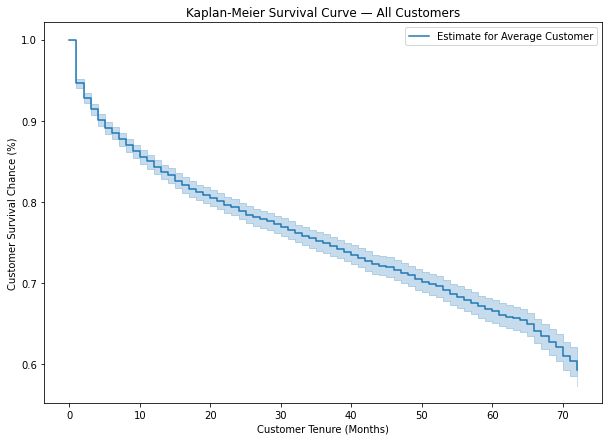

In [11]:
# fitting kmf to churn data
t = churn_data['tenure'].values
churn = churn_data['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')
# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

The above should give us some basic intuition about the customers.  

As we would expect for telecom, churn is relatively low. Even after 72 months, the company is able to retain 60% or more of their customers.  

To examine the effects of different features, we will use the Cox Proportional Hazards Model. We can think of this as a Survival Regression model.  

'Hazards' can be thought of something that would increase/decrease chances of survival. In our business problem, for example, a hazard may be the type of contract a customer has. Customers with multi-year contracts probably cancel less frequently than those with month-to-month contracts.  

One restriction is the model assumes a constant ratio of hazards over time across groups. Lifeline offers a built in check_assumptions method for the CoxPHFitter object.  

After some data cleaning, including encoding categorical variables (k-1 dummies), we can fit a survival regression model to the data.

In [0]:
features_to_drop = ['customerID', 'gender', 'PhoneService', 'InternetService']
# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard = churn_data.drop(features_to_drop, axis=1).copy()

# convert some stuff to integers
churn_hazard['TotalCharges'] = pd.to_numeric(churn_hazard['TotalCharges'], errors='coerce')
churn_hazard['TotalCharges'].fillna(0, inplace=True)

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV','StreamingMovies', 'PaperlessBilling']
for feat in binary_features:
    churn_hazard[feat] = churn_hazard[feat] == 'Yes'
    
# let's one hot encode the remaining categorical features
ohe_features = ['MultipleLines', 'Contract', 'PaymentMethod']
churn_hazard = pd.get_dummies(churn_hazard, 
                              drop_first=True,
                              columns=ohe_features)

In [13]:
churn_hazard

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,True,False,1.0,False,True,False,False,False,False,True,29.85,29.85,False,1,0,0,0,0,1,0
1,0,False,False,34.0,True,False,True,False,False,False,False,56.95,1889.50,False,0,0,1,0,0,0,1
2,0,False,False,2.0,True,True,False,False,False,False,True,53.85,108.15,True,0,0,0,0,0,0,1
3,0,False,False,45.0,True,False,True,True,False,False,False,42.30,1840.75,False,1,0,1,0,0,0,0
4,0,False,False,2.0,False,False,False,False,False,False,True,70.70,151.65,True,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,True,True,24.0,True,False,True,True,True,True,True,84.80,1990.50,False,0,1,1,0,0,0,1
7039,0,True,True,72.0,False,True,True,False,True,True,True,103.20,7362.90,False,0,1,1,0,1,0,0
7040,0,True,True,11.0,True,False,False,False,False,False,True,29.60,346.45,False,1,0,0,0,0,1,0
7041,1,True,False,4.0,False,False,False,False,False,False,True,74.40,306.60,True,0,1,0,0,0,0,1


In [14]:
cph = lifelines.CoxPHFitter()
cph.fit(churn_hazard, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

In the above regression, the key output is exp(coef). This is interpreted as the scaling of hazard risk for each additional unit of the variable, 1.00 being neutral.    

For example, the last exp(coefficient), corresponding to PaymentMethod_Mailed check, means a customer that pays by mailing a check is 1.68 times as likely to cancel their service.  

For the company, exp(coef) below 1.0 is good, meaning a customer less likely to cancel.  

To better visualize the above, we can plot the coefficient outputs and their confidence intervals.

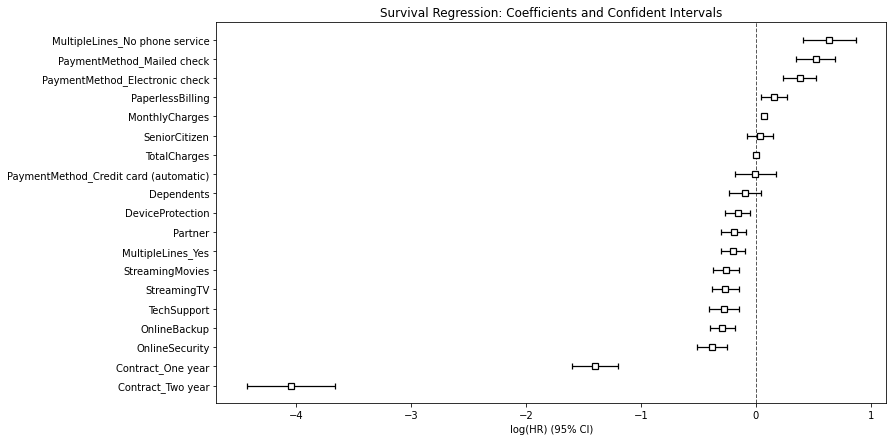

In [15]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

In [0]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='tenure', event='Churn', df=churn_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

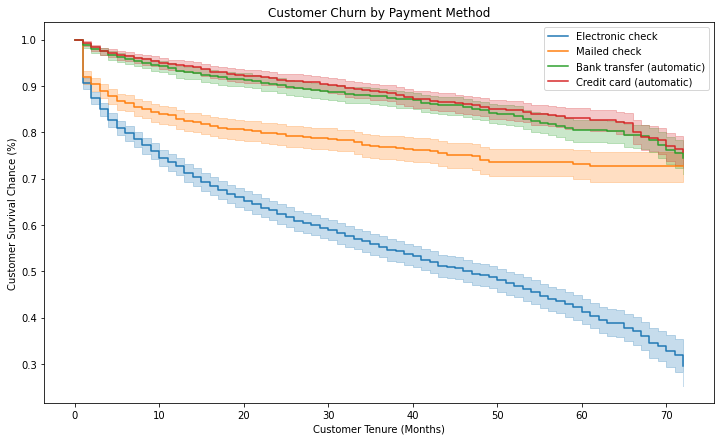

In [17]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='PaymentMethod', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Payment Method')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()

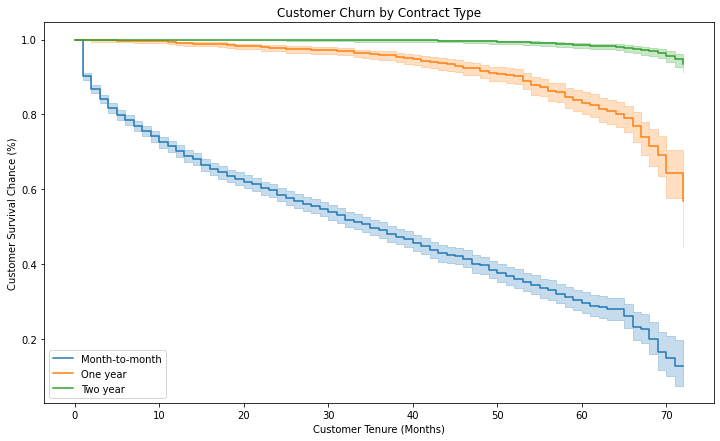

In [18]:
fig_contract, ax_contract = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Contract', ax=ax_contract)
ax_contract.set_title('Customer Churn by Contract Type')
ax_contract.set_xlabel('Customer Tenure (Months)')
ax_contract.set_ylabel('Customer Survival Chance (%)')
plt.show()

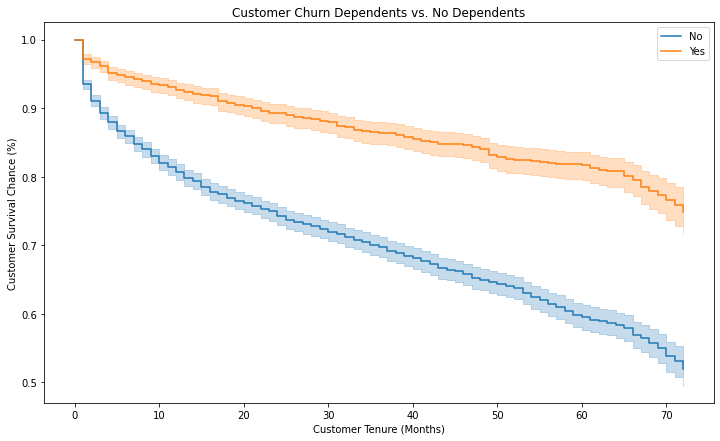

In [19]:
fig_dep, ax_dep = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Dependents', ax=ax_dep)
ax_dep.set_title('Customer Churn Dependents vs. No Dependents')
ax_dep.set_xlabel('Customer Tenure (Months)')
ax_dep.set_ylabel('Customer Survival Chance (%)')
plt.show()

# The Conclusion:
How can our telecom company reduce customer churn?  
We can make recommendations along 3 dimensions: contract specification, customer selection, and payment systems.   
To visualize some of our findings, we will fit categorically based Kaplan-Meier curves and plot them.  

# Contract Specification
The most important feature, by far, is the presence of a 1 or 2 year contract. Customers are .25 and .02, respectively, times as likely to cancel their service if they are under contract.    
Cancellation fees are a possible underlying cause.  
As long as these fees do not prohibit new sales, we would recommend continuing to put them into as many contracts as possible.

# Customer Selection
Customers with a partner or dependents are .82 and .91 times as likely to cancel as normal customers.   
Families and other large households seem to be less likely to change providers.
This could be due to higher incomes, less time to consider options, or another combination of factors.  

# Payment Systems
There is a reason companies now default to opting employees into 401k plans. It takes effort for people to make a change, even if it is beneficial.   
Make sure your customer's default is an automatic payment made monthly. This requires little effort from the customer to remain subscribed.  
Conversely, sending a check, in the mail or electronically, is a pain. It requires effort to remain subscribed.